<a href="https://colab.research.google.com/github/Susrinivas/690-stats-and-visu/blob/main/assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment-6

Please find 2 ML-based anomaly detection algorithms (other than Elliptic Envelope) and do the following:

    * Explain the theory (working logic) of these models.
    * Given a stock(s) of your choice, run these models, find the anomalies and compare the results.
    
**Note:** You do not need to apply hard math to explain everything behind these models.

In [1]:
#!pip install pandas==0.23.4

In [2]:
#codes here
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
pd.set_option('use_inf_as_na', True)
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [3]:
pd.__version__

'1.3.5'

In [4]:
crash_data = pd.read_csv('crash_data.csv')

In [5]:
crash_data.head()

,Unnamed: 0,RET,date,TICKER,vwretx,BIDLO,ASKHI,PRC,VOL
0,27882462,0.041833,20100104,BAC,0.017045,15.12,15.750,15.69,180845100.0
1,27882463,0.032505,20100105,BAC,0.003362,15.70,16.210,16.20,209521200.0
2,27882464,0.011728,20100106,BAC,0.001769,16.03,16.540,16.39,205257900.0
3,27882465,0.032947,20100107,BAC,0.002821,16.51,17.185,16.93,320868400.0
4,27882466,-0.008860,20100108,BAC,0.004161,16.63,17.100,16.78,220104600.0


In [6]:
crash_data.date = pd.to_datetime(crash_data.date, format='%Y%m%d')
crash_data = crash_data.set_index('date')

In [7]:
crash_dataw = crash_data.groupby('TICKER').resample('W').\
              agg({'RET':'mean', 'vwretx':'mean', 'VOL':'mean',
                   'BIDLO':'mean', 'ASKHI':'mean', 'PRC':'mean'})

In [8]:
crash_dataw = crash_dataw.reset_index()
crash_dataw.dropna(inplace=True)
stocks = crash_dataw.TICKER.unique()

In [9]:
crash_dataw

,TICKER,date,RET,vwretx,VOL,BIDLO,ASKHI,PRC
0,AAPL,2010-01-10,0.001235,0.005832,18980442.8,210.898000,213.864000,212.383998
1,AAPL,2010-01-17,-0.005719,-0.002080,19772230.6,206.772002,211.152002,208.767994
2,AAPL,2010-01-24,-0.009510,-0.009479,25930885.0,205.277505,212.888450,208.146752
3,AAPL,2010-01-31,-0.005426,-0.003738,52020594.0,198.250202,207.338002,201.650398
4,AAPL,2010-02-07,0.003722,-0.001463,26953208.4,192.304004,197.378002,195.466002
...,...,...,...,...,...,...,...,...
13398,XOM,2019-12-08,0.004058,0.000184,12371989.0,68.199000,68.946000,68.574000
13399,XOM,2019-12-15,-0.000734,0.001344,13958017.0,68.882000,70.160000,69.450000
13400,XOM,2019-12-22,0.002067,0.003199,18338291.4,69.384000,70.239340,69.776000
13401,XOM,2019-12-29,-0.000172,0.001220,9378504.5,69.832525,70.403075,70.082500


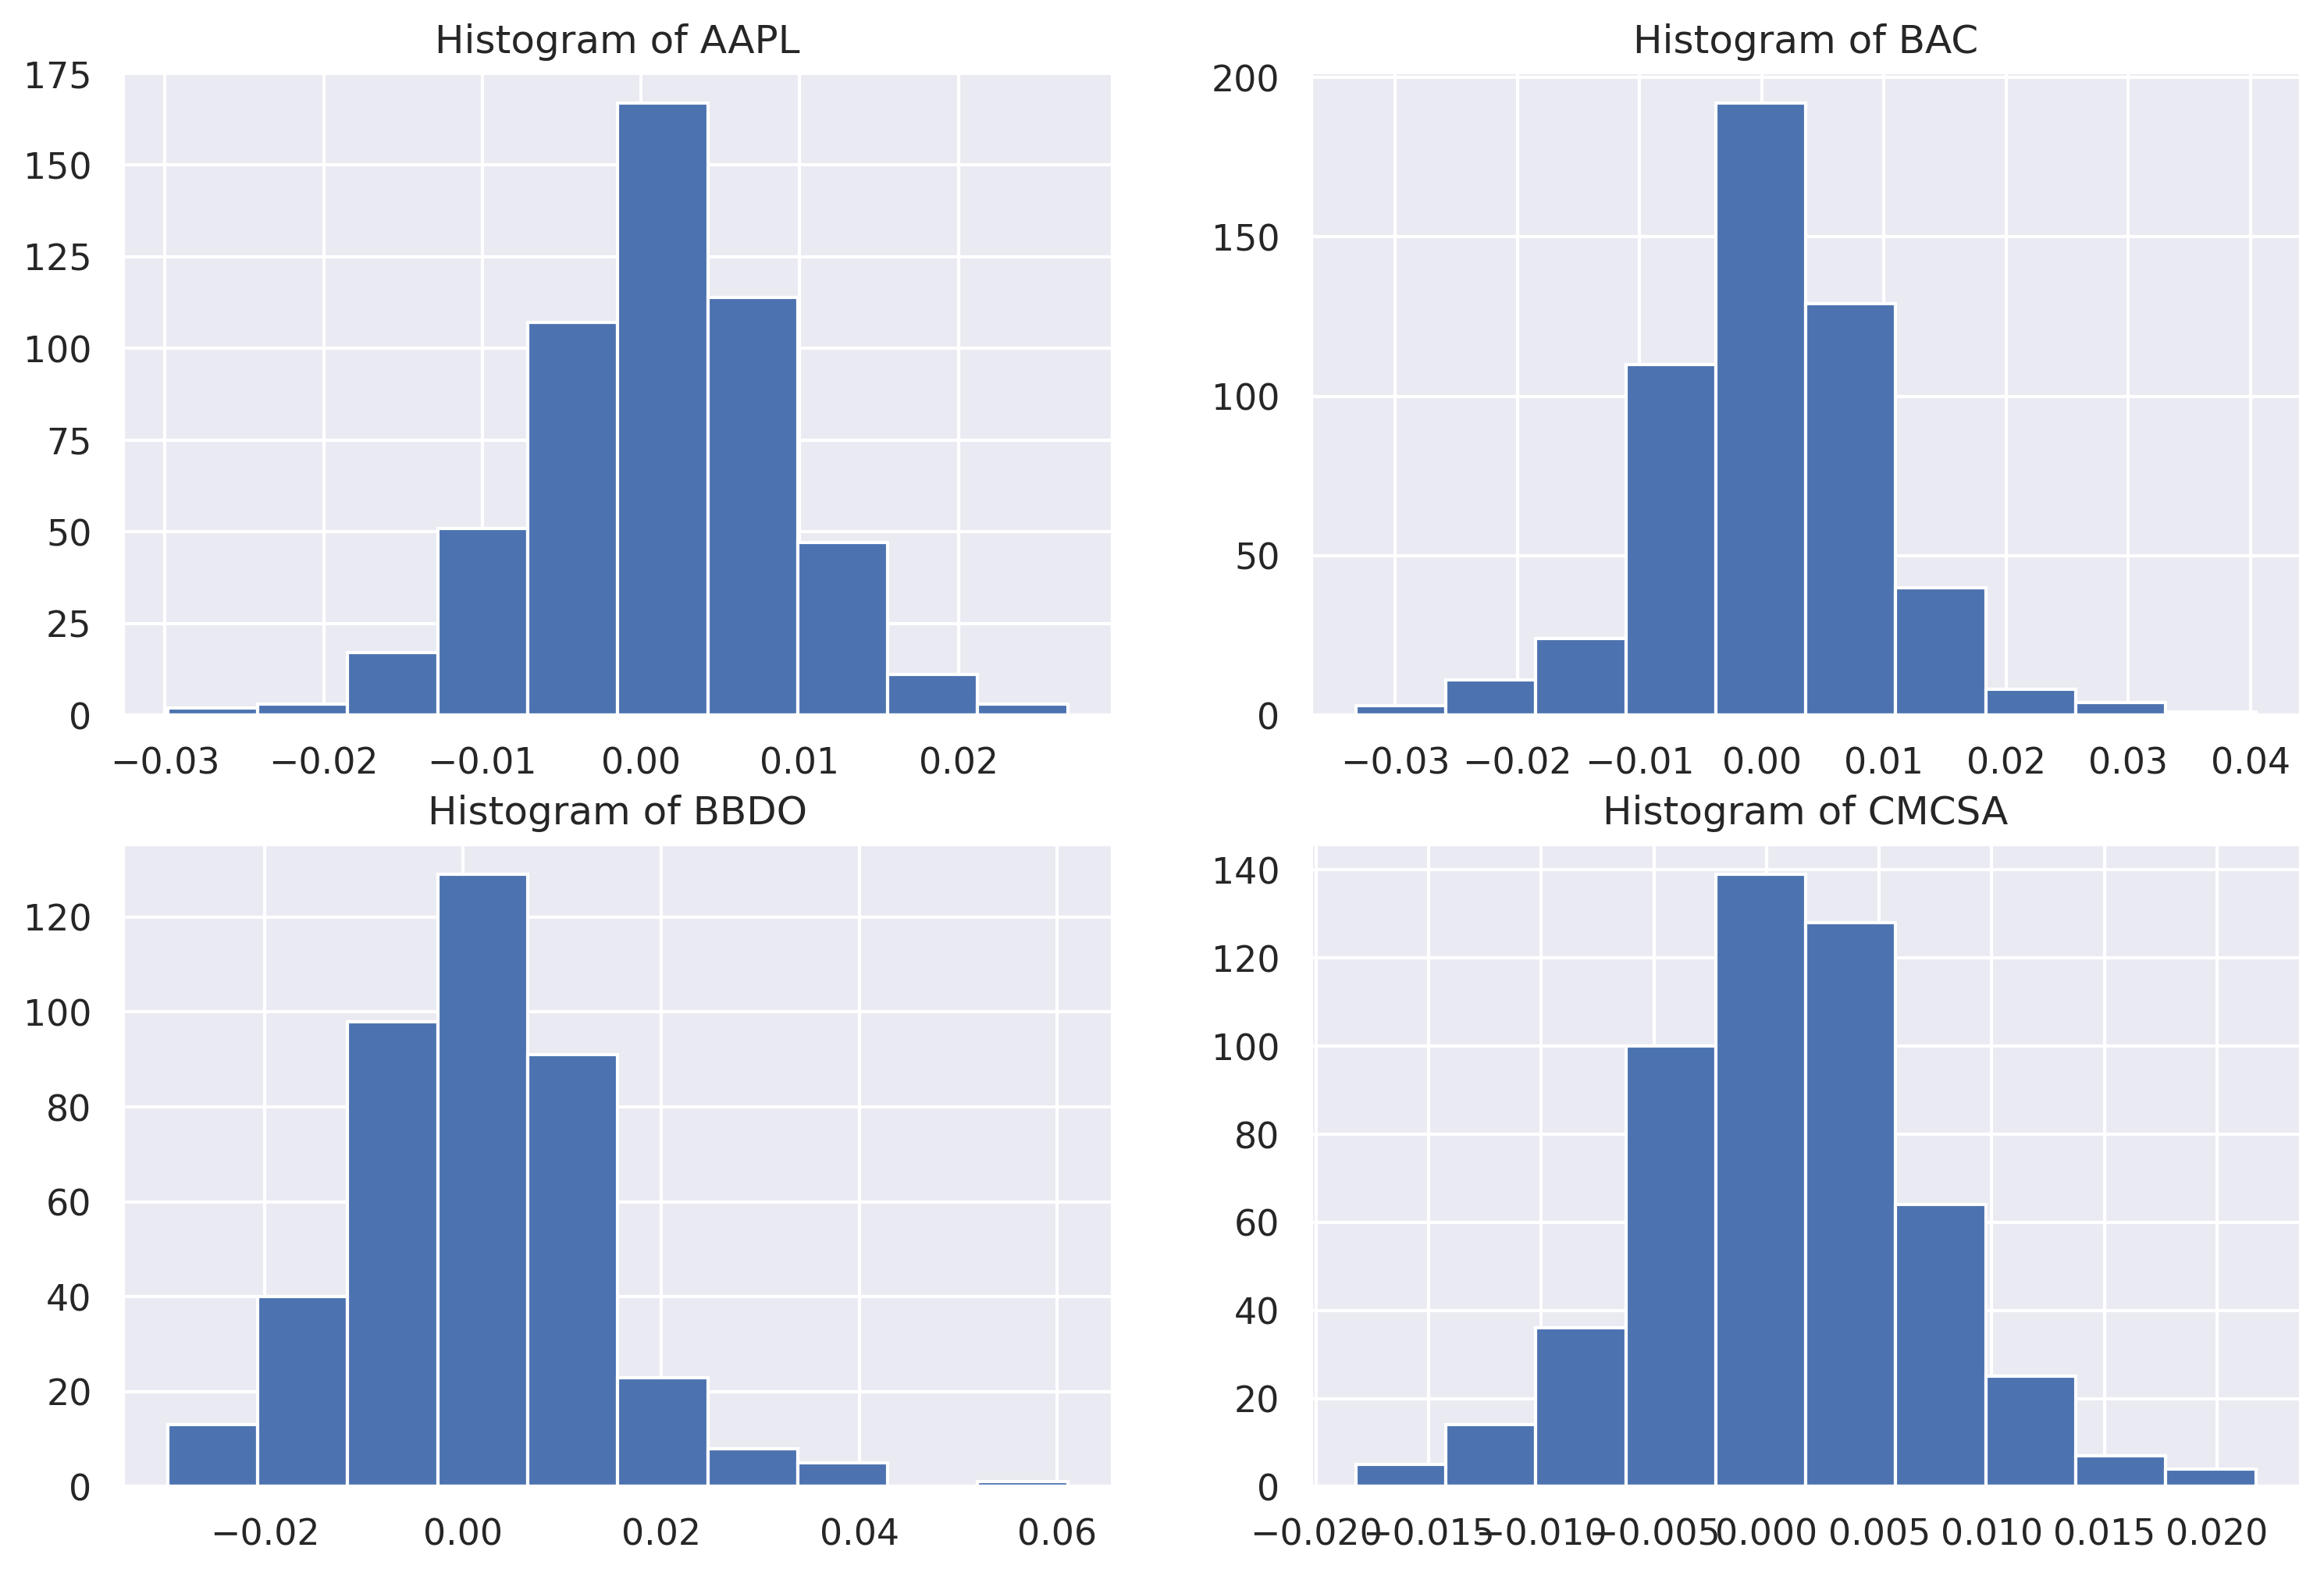

In [10]:
plt.figure(figsize=(12, 8))
k = 1

for i in stocks[: 4]:
    plt.subplot(2, 2, k)
    plt.hist(crash_dataw[crash_dataw.TICKER == i]['RET'])
    plt.title('Histogram of '+i)
    k+=1
plt.show()

## Firm-specific return

In [11]:
import statsmodels.api as sm
residuals = []

for i in stocks:
    Y = crash_dataw.loc[crash_dataw['TICKER'] == i]['RET'].values
    X = crash_dataw.loc[crash_dataw['TICKER'] == i]['vwretx'].values
    X = sm.add_constant(X)
    ols = sm.OLS(Y[2:-2], X[2:-2] + X[1:-3] + X[0:-4] + \
                 X[3:-1] + X[4:]).fit()
    residuals.append(ols.resid)

In [12]:
residuals = list(map(lambda x: np.log(1 + x), residuals))

In [13]:
crash_data_sliced = pd.DataFrame([])
for i in stocks:
    crash_data_sliced = crash_data_sliced.append(crash_dataw.loc[crash_dataw.TICKER == i]
                               [2:-2])
crash_data_sliced.head()

,TICKER,date,RET,vwretx,VOL,BIDLO,ASKHI,PRC
2,AAPL,2010-01-24,-0.009510,-0.009479,25930885.00,205.277505,212.888450,208.146752
3,AAPL,2010-01-31,-0.005426,-0.003738,52020594.00,198.250202,207.338002,201.650398
4,AAPL,2010-02-07,0.003722,-0.001463,26953208.40,192.304004,197.378002,195.466002
5,AAPL,2010-02-14,0.005031,0.002970,19731018.60,194.513998,198.674002,196.895200
6,AAPL,2010-02-21,0.001640,0.007700,16618997.25,201.102500,203.772500,202.636995


In [14]:
len(crash_data_sliced)

13286

## Isolation Forest

In [15]:
from sklearn.ensemble import IsolationForest
isolation_model = IsolationForest(contamination = 0.02)
if_predictions = {}

for i, j in zip(range(len(stocks)), stocks):
  isolation_model.fit(np.array(residuals[i]).reshape(-1, 1))
  if_predictions[j] = isolation_model.predict(np.array(residuals[i])
                                         .reshape(-1, 1))

In [16]:
transform = []

for i in stocks:
    for j in range(len(if_predictions[i])):
        transform.append(np.where(if_predictions[i][j] == 1, 0, -1))

In [17]:
crash_data_sliced = crash_data_sliced.reset_index()
crash_data_sliced['residuals'] = np.concatenate(residuals)
crash_data_sliced['neg_outliers'] = np.where((np.array(transform)) == -1, 1, 0)
crash_data_sliced.loc[(crash_data_sliced.neg_outliers == 1) &
                      (crash_data_sliced.residuals > 0),
                      'neg_outliers'] = 0

In [18]:
crash_data_sliced['neg_outliers'].value_counts()

0    13148
1      138
Name: neg_outliers, dtype: int64

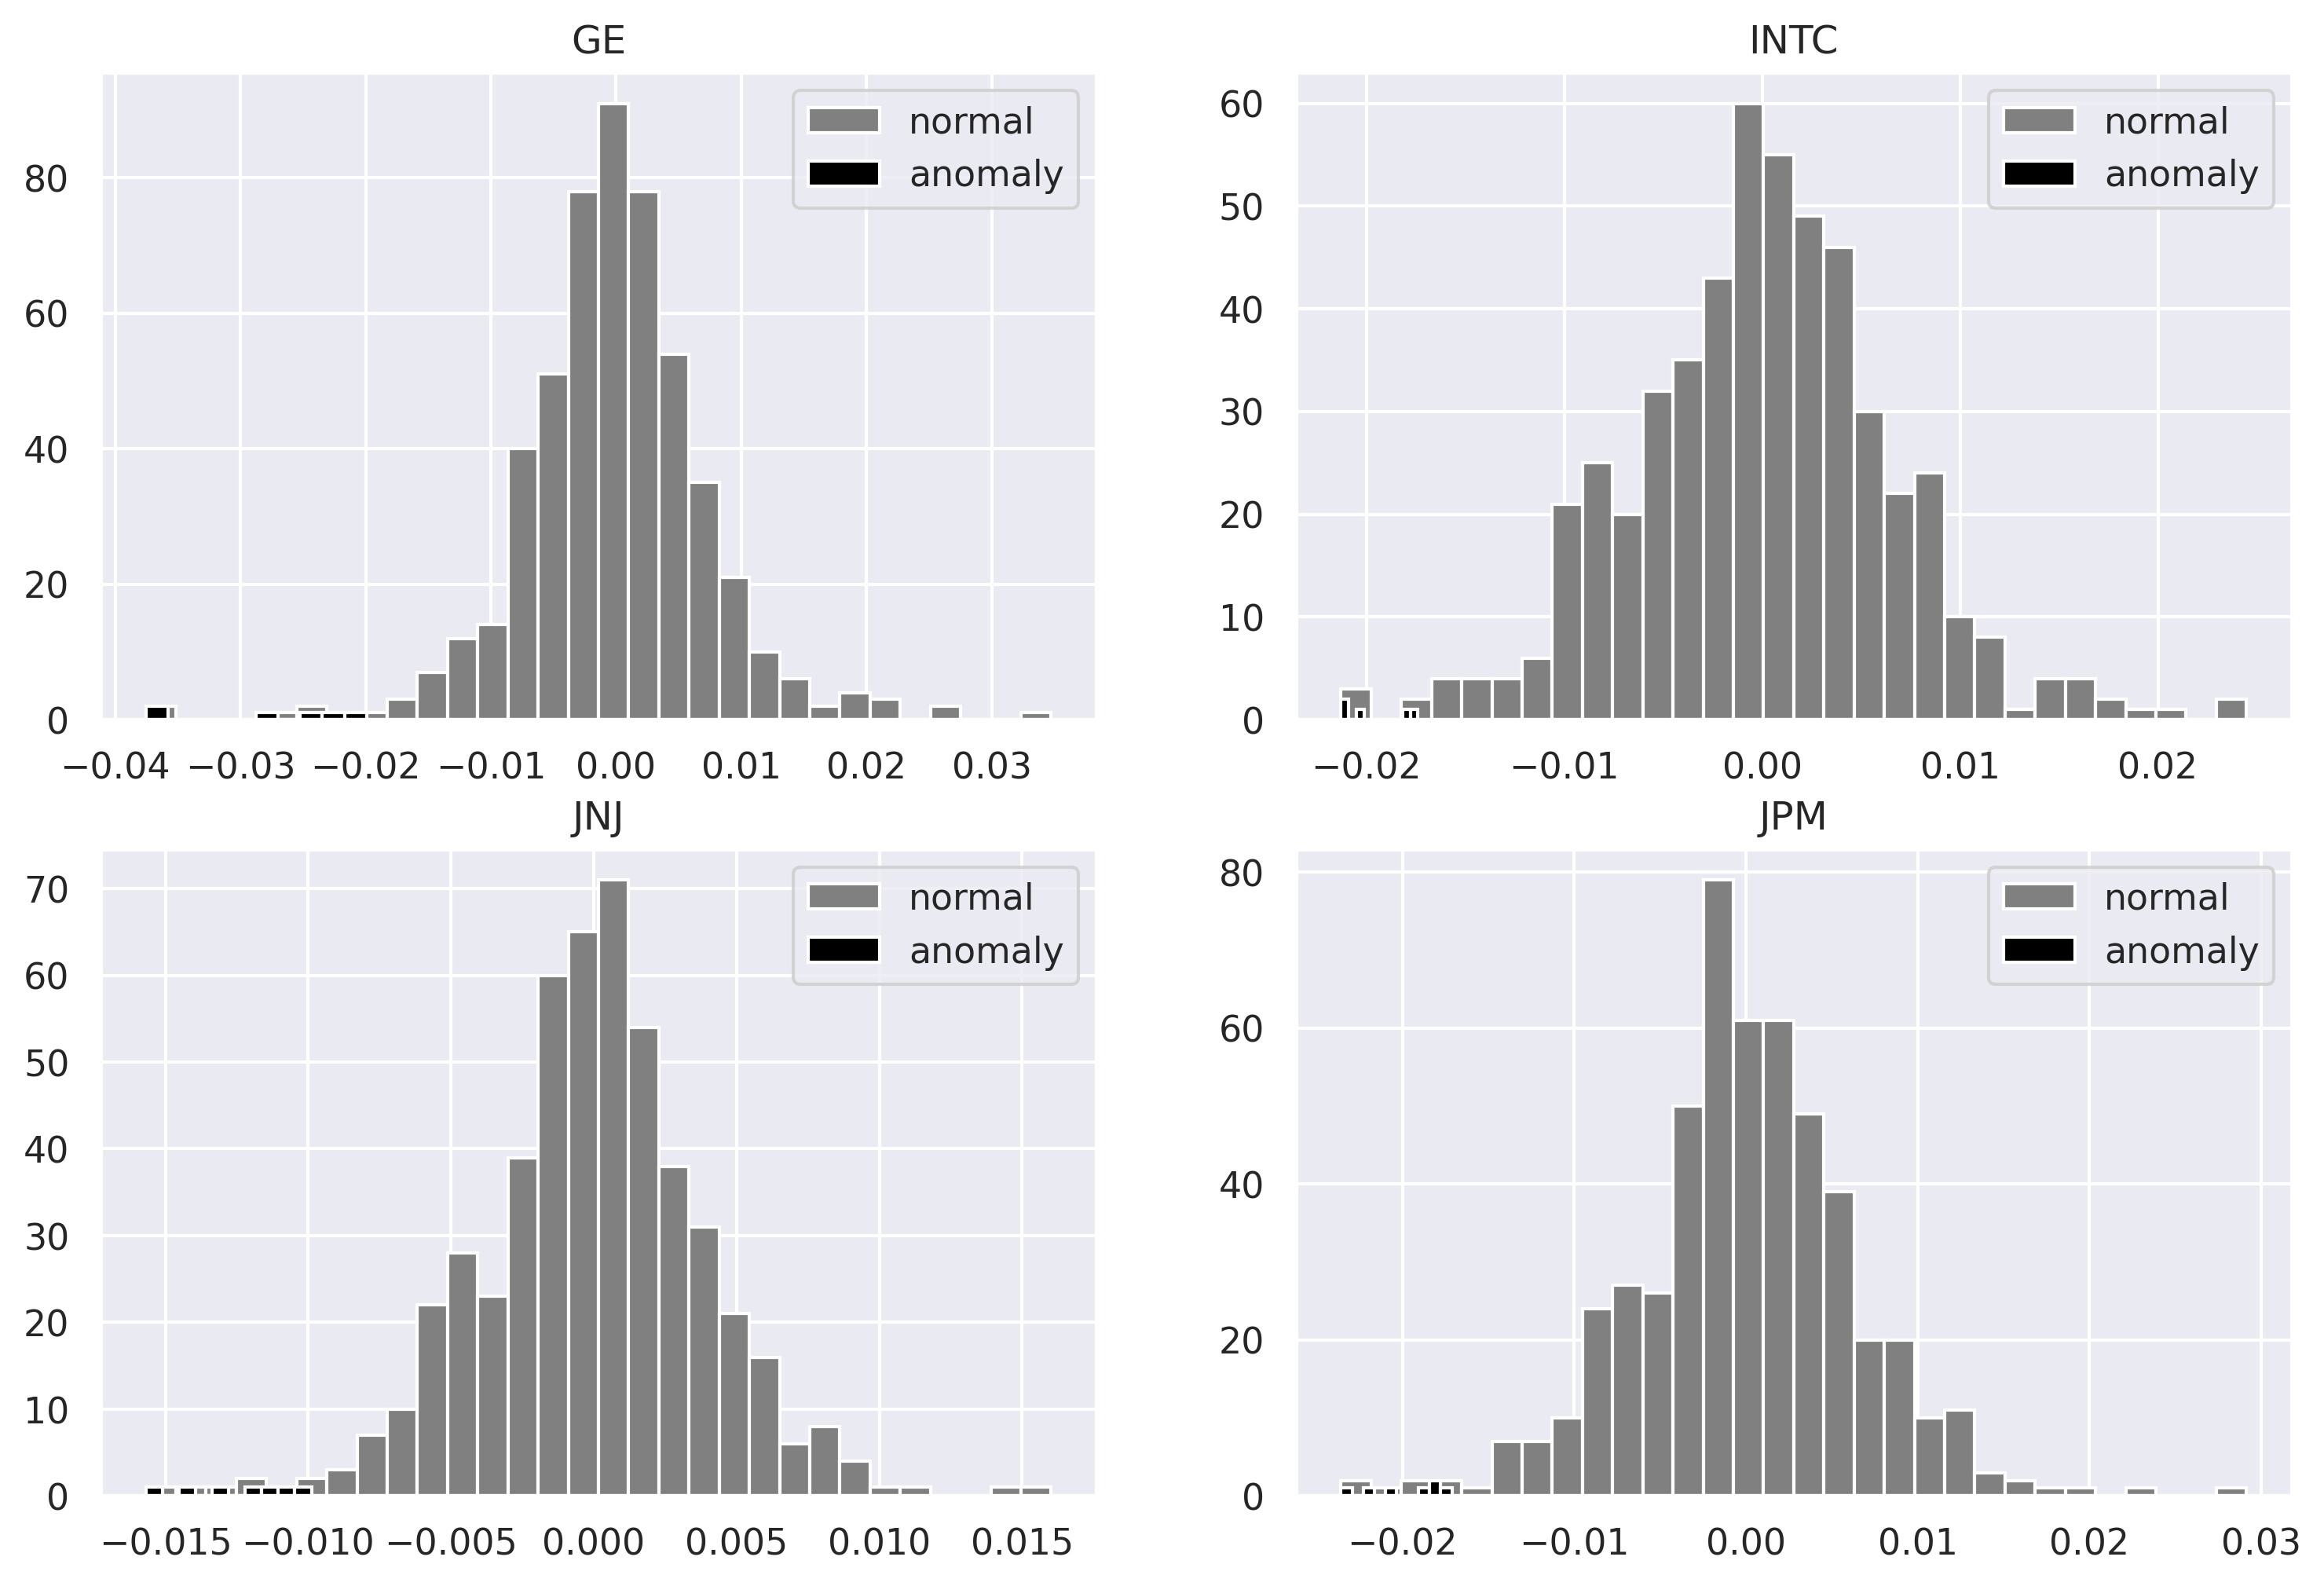

In [19]:
plt.figure(figsize=(12, 8)) 
k=1

for i in stocks[8:12]:
    plt.subplot(2, 2, k)
    crash_data_sliced['residuals'][crash_data_sliced.TICKER == i]\
    .hist(label='normal', bins=30, color='gray')
    outliers = crash_data_sliced['residuals'][(crash_data_sliced.TICKER == i) &
    (crash_data_sliced.neg_outliers > 0)]
    outliers.hist(color='black', label='anomaly') 
    plt.title(i)
    plt.legend()
    k+=1

In [20]:
crash_data_sliced = crash_data_sliced.set_index('date')
crash_data_sliced.index = pd.to_datetime(crash_data_sliced.index)

In [21]:
std = crash_data.groupby('TICKER')['RET'].resample('W').std()\
      .reset_index()
crash_dataw['std'] = pd.DataFrame(std['RET'])

In [22]:
yearly_data = crash_data_sliced.groupby('TICKER')['residuals']\
.resample('Y').agg(residuals={'mean', 'std'})\
.reset_index()
yearly_data.columns = ['TICKER', 'date', 'mean', 'std']
yearly_data.head()

TypeError: ignored

In [23]:
yearly_data = crash_data_sliced.groupby('TICKER')['residuals']\
              .resample('Y').agg({'residuals':{'mean', 'std'}})\
              .reset_index()
yearly_data.columns = ['TICKER', 'date', 'mean', 'std']
yearly_data.head()

SpecificationError: ignored

REF:
1.https://hands-on.cloud/using-python-and-isolation-forest-algorithm-for-anomalies-detection/

2. datatechnotes.com/2020/04/anomaly-detection-with-dbscan-in-python.html

3.https://www.datatechnotes.com/2020/04/anomaly-detection-with-one-class-svm.html

